In [ ]:
!pip install shapely pycocotools opencv-python

Weekly Growth Report:
        week  ground_area      growth
0 2024-09-02   583.213064         NaN
1 2024-09-09   861.402221  278.189157
2 2024-09-16  1384.615771  523.213550
3 2024-09-23  1554.844111  170.228341
4 2024-09-30  1684.453695  129.609583


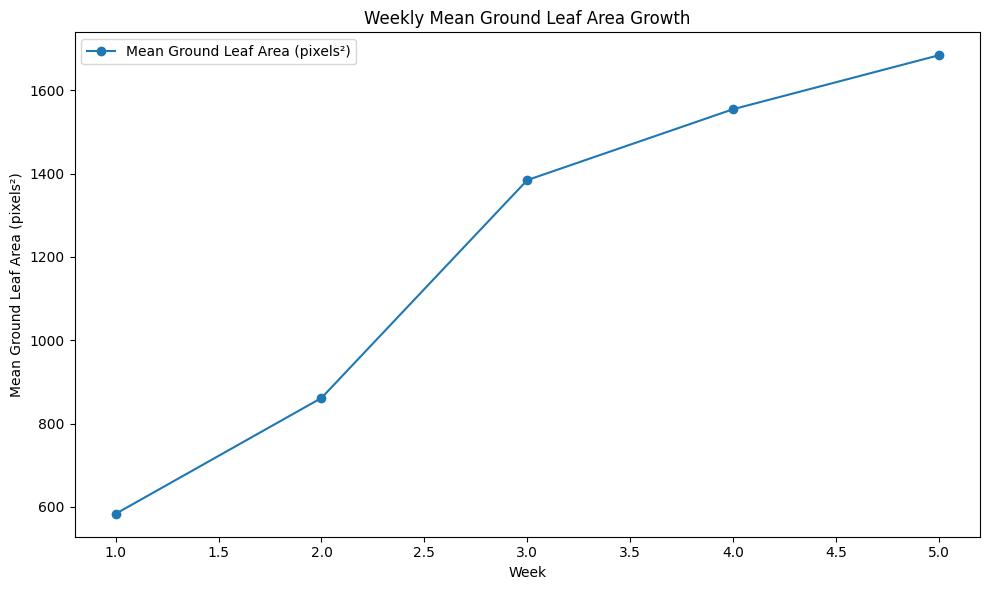

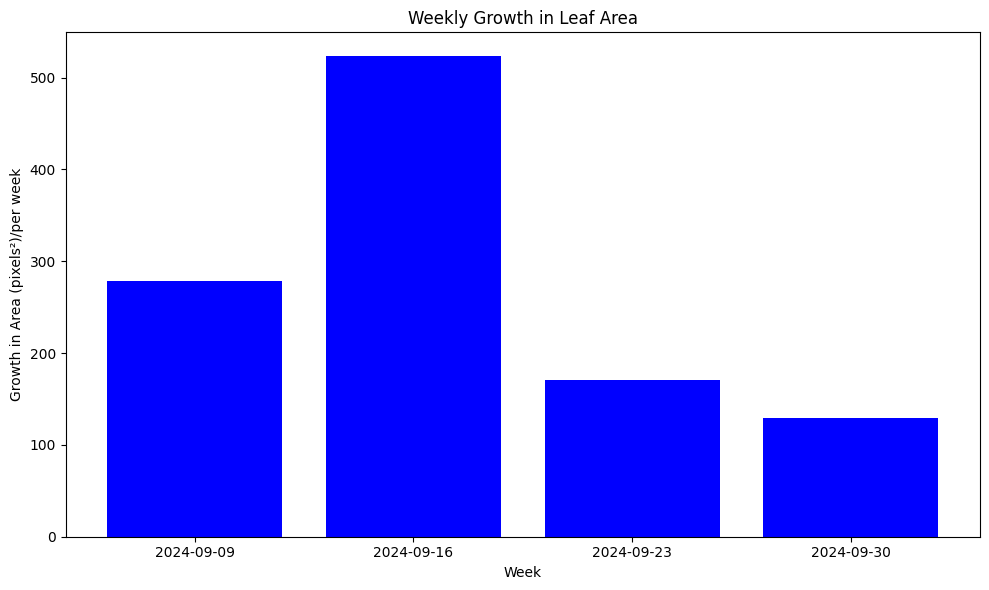

In [ ]:
import json
import os
import re
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from pycocotools import mask as cocomask
import matplotlib.pyplot as plt

root_path = '/content/drive/MyDrive/Colab Notebooks/Leaf Area Project/Leaf Area.v1i.coco'
train_path = os.path.join(root_path, 'train')
valid_path = os.path.join(root_path, 'valid')
test_path  = os.path.join(root_path, 'test')

def load_coco_annotations(json_file, img_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    image_info = {img['id']: (img['file_name'], img['width'], img['height']) for img in data['images']}

    entries = []
    for ann in data['annotations']:
        segmentation = ann['segmentation'][0]
        image_id = ann['image_id']
        file_name, img_width, img_height = image_info[image_id]

        polygon_coords = list(zip(segmentation[0::2], segmentation[1::2]))
        polygon = Polygon(polygon_coords)
        area_pixels = polygon.area

        entries.append({
            'image_id': image_id,
            'file_name': file_name,
            'ground_area': area_pixels,
            'img_dir': img_dir
        })
    return entries

train_data = load_coco_annotations(os.path.join(train_path, '_annotations.coco.json'), train_path)
valid_data = load_coco_annotations(os.path.join(valid_path, '_annotations.coco.json'), valid_path)
test_data  = load_coco_annotations(os.path.join(test_path, '_annotations.coco.json'), test_path)

all_data = train_data + valid_data + test_data
df = pd.DataFrame(all_data)

date_pattern = re.compile(r'(\d{4}-\d{2}-\d{2})')  # YYYY-MM-DD

def extract_date(filename):
    match = date_pattern.search(filename)
    if match:
        return pd.to_datetime(match.group(1))
    else:
        return None

df['date'] = df['file_name'].apply(extract_date)
df = df.dropna(subset=['date'])
df = df.sort_values('date')

df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_stats = df.groupby('week', as_index=False)['ground_area'].mean()
weekly_stats = weekly_stats.sort_values('week')
weekly_stats['growth'] = weekly_stats['ground_area'].diff()

print("Weekly Growth Report:")
print(weekly_stats)

lis = [1, 2, 3, 4, 5]
plt.figure(figsize=(10, 6))
plt.plot(lis, weekly_stats['ground_area'], marker='o', label='Mean Ground Leaf Area (pixels²)')
plt.xlabel('Week')
plt.ylabel('Mean Ground Leaf Area (pixels²)')
plt.title('Weekly Mean Ground Leaf Area Growth')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

lis = [ 2, 3, 4, 5]
plt.figure(figsize=(10,6))
plt.bar(weekly_stats['week'].astype(str), weekly_stats['growth'], color='blue')
plt.xlabel('Week')
plt.ylabel('Growth in Area (pixels²)/per week')
plt.title('Weekly Growth in Leaf Area')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display, HTML
import pandas as pd
# week  ground_area      growth
# 0 2024-09-02   583.213064         NaN
# 1 2024-09-09   861.402221  278.189157
# 2 2024-09-16  1384.615771  523.213550
# 3 2024-09-23  1554.844111  170.228341
# 4 2024-09-30  1684.453695  129.609583

df=pd.DataFrame(
    {
        "Week":[1,2,3,4,5],
        "Date":['2024-09-02','2024-09-09','2024-09-16','2024-09-23','2024-09-30'],
        "Mean Leaf Area (Pixel\u00B2)":[583.21,861.40,1384.61,1554.84,1684.45],
        "Growth Rate (Pixel\u00B2/week)":[583.21,278.18,523.21,170.22,129.60]
    }
)
display(df)

,Week,Date,Mean Leaf Area (Pixel²),Growth Rate (Pixel²/week)
0,1,2024-09-02,583.21,583.21
1,2,2024-09-09,861.40,278.18
2,3,2024-09-16,1384.61,523.21
3,4,2024-09-23,1554.84,170.22
4,5,2024-09-30,1684.45,129.60


In [ ]:
!pip install prettytable
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = df.columns.tolist()

for _, row in df.iterrows():
    pt.add_row(row.tolist())

print(pt)

+------+------------+-----------------------+------------------------+
| Week |    Date    | Mean Leaf Area Pixel² | Growth Pixel² per week |
+------+------------+-----------------------+------------------------+
|  1   | 2024-09-02 |         583.21        |         583.21         |
|  2   | 2024-09-09 |         861.4         |         278.18         |
|  3   | 2024-09-16 |        1384.61        |         523.21         |
|  4   | 2024-09-23 |        1554.84        |         170.22         |
|  5   | 2024-09-30 |        1684.45        |         129.6          |
+------+------------+-----------------------+------------------------+
